### Este código irá:

- Carregar o modelo e os dados de teste.

- Gerar as probabilidades de predição.

- Varrer uma gama de thresholds.

- Calcular Precision, Recall e F1-score para cada threshold.

- Plotar essas métricas em um gráfico interativo.

✅ Modelo, features e dados de teste carregados com sucesso.
Número de features no modelo: 48
Formato X_test: (294, 48), y_test: (294,)
X_test alinhado com as features do modelo.
✅ Probabilidades de predição geradas.
✅ Métricas calculadas para diferentes thresholds.


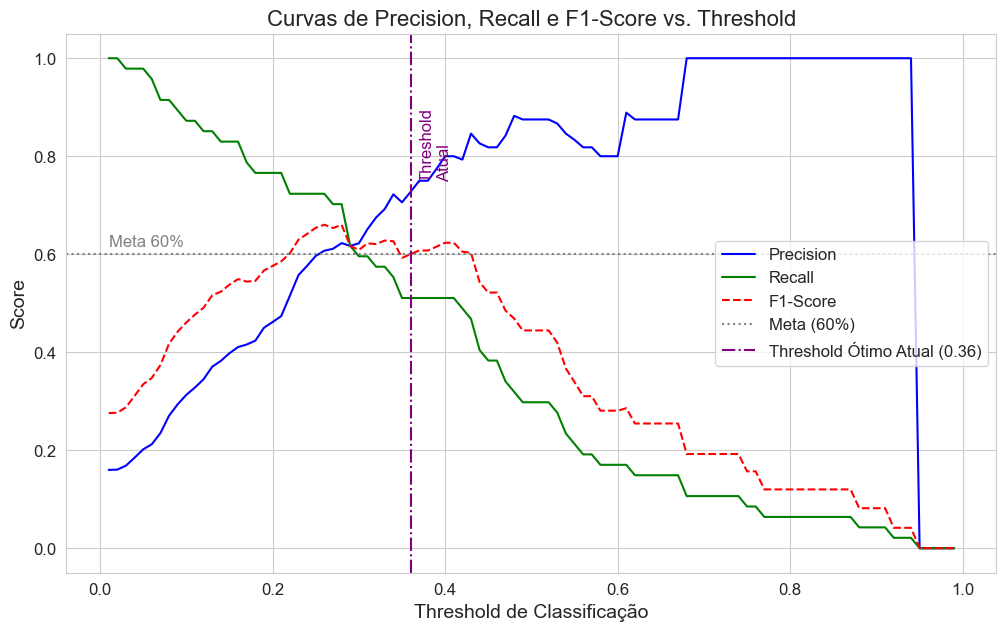


--- Thresholds que atendem às suas metas (P>=60%, R>=60%, F1>=60%) ---
Threshold: 0.26
  Precision: 0.61
  Recall: 0.72
  F1-Score: 0.66


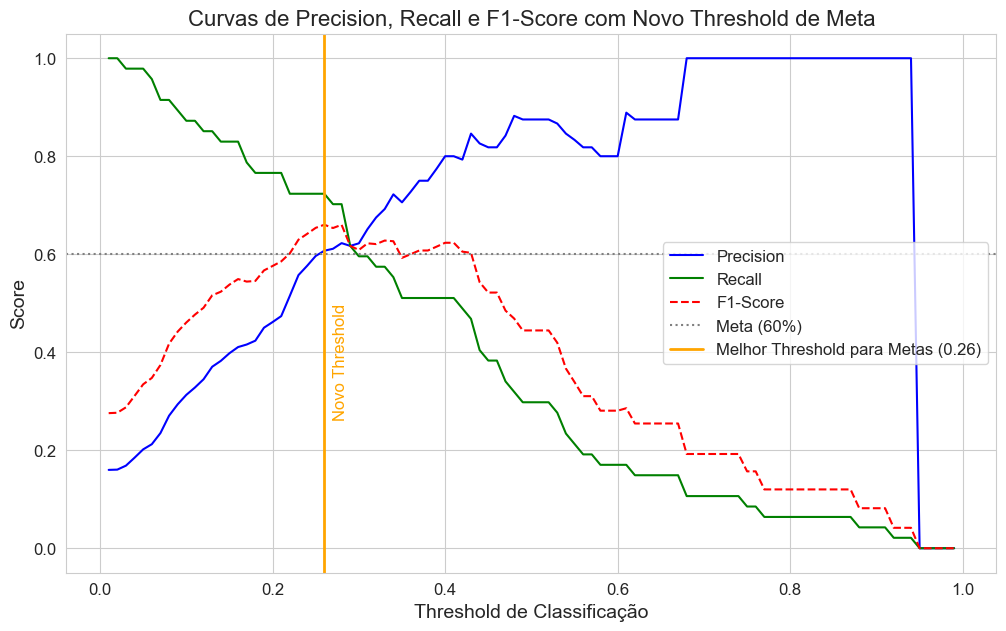

In [1]:
# notebooks/threshold_optimization_curves.ipynb

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
import os
from pathlib import Path

# --- Configurações de visualização ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# --- Caminhos para os artefatos do modelo ---
project_root = Path(os.getcwd()).parent # Assume que o notebook está em 'notebooks'
                                       # e o projeto root é o diretório pai

MODEL_PATH = project_root / "models" / "production_model.pkl"
FEATURES_PATH = project_root / "artifacts" / "features" / "features.pkl"
X_TEST_PATH = project_root / "artifacts" / "features" / "X_test.csv"
Y_TEST_PATH = project_root / "artifacts" / "features" / "y_test.csv"

# --- Carregar artefatos ---
try:
    model = joblib.load(MODEL_PATH)
    model_features = joblib.load(FEATURES_PATH)
    X_test = pd.read_csv(X_TEST_PATH)
    y_test = pd.read_csv(Y_TEST_PATH).squeeze("columns") # .squeeze para garantir que é uma Series
    
    print("✅ Modelo, features e dados de teste carregados com sucesso.")
    print(f"Número de features no modelo: {len(model_features)}")
    print(f"Formato X_test: {X_test.shape}, y_test: {y_test.shape}")

    # Verificar e reindexar X_test para garantir compatibilidade com o modelo
    X_test_aligned = X_test.reindex(columns=model_features, fill_value=0.0)
    print("X_test alinhado com as features do modelo.")

    # Se o modelo for um pipeline (ex: com um `StandardScaler` interno no `data_processing.py`),
    # é importante que o X_test_aligned não seja escalado novamente aqui se o modelo já fizer isso.
    # No seu setup atual, o `data_processing.py` faz o escalonamento, então o X_test_aligned
    # (se fosse gerado por ele) já estaria escalado.
    # Como X_test.csv é gerado pelo `train.py` (que tem seu próprio preprocess),
    # certifique-se que o escalonamento do `train.py` é consistente.
    # A maneira mais segura seria ter um scaler salvo e carregá-lo, ou garantir
    # que o `preprocess` do `train.py` faça o escalonamento.

except FileNotFoundError as e:
    print(f"❌ Erro: Arquivo não encontrado. Certifique-se de que o pipeline foi executado e os artefatos existem. Detalhes: {e}")
    # Você pode querer parar a execução do notebook aqui se os arquivos forem críticos
    raise
except Exception as e:
    print(f"❌ Erro ao carregar artefatos: {e}")
    raise

# --- Gerar probabilidades ---
y_pred_proba = model.predict_proba(X_test_aligned)[:, 1]
print("✅ Probabilidades de predição geradas.")

# --- Varrendo thresholds e coletando métricas ---
thresholds = np.arange(0.01, 1.00, 0.01) # thresholds de 0.01 a 0.99
metrics = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Usar zero_division=0 para evitar warnings se não houver predições para a classe positiva
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    })

metrics_df = pd.DataFrame(metrics)
print("✅ Métricas calculadas para diferentes thresholds.")

# --- Plotando as curvas ---
plt.figure(figsize=(12, 7))
plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', color='blue')
plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', color='green')
plt.plot(metrics_df['threshold'], metrics_df['f1_score'], label='F1-Score', color='red', linestyle='--')

# Adicionar linhas de meta
plt.axhline(y=0.60, color='gray', linestyle=':', linewidth=1.5, label='Meta (60%)')
plt.text(0.01, 0.61, 'Meta 60%', color='gray', va='bottom')

# Adicionar o threshold ótimo encontrado pelo evaluate.py (se você quiser plotá-lo)
try:
    optimal_threshold_path = project_root / "artifacts" / "models" / "optimal_threshold.pkl"
    optimal_threshold_value = joblib.load(optimal_threshold_path)
    plt.axvline(x=optimal_threshold_value, color='purple', linestyle='-.', linewidth=1.5, label=f'Threshold Ótimo Atual ({optimal_threshold_value:.2f})')
    plt.text(optimal_threshold_value + 0.01, 0.9, f'Threshold\nAtual', color='purple', rotation=90, va='top')
except FileNotFoundError:
    print("Aviso: Arquivo de threshold ótimo não encontrado para plotagem.")
except Exception as e:
    print(f"Aviso: Erro ao carregar threshold ótimo para plotagem: {e}")


plt.xlabel('Threshold de Classificação')
plt.ylabel('Score')
plt.title('Curvas de Precision, Recall e F1-Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# --- Encontrar o threshold que atende às suas novas metas (se houver) ---
target_precision = 0.60
target_recall = 0.60
target_f1 = 0.60

potential_thresholds = metrics_df[
    (metrics_df['precision'] >= target_precision) &
    (metrics_df['recall'] >= target_recall) &
    (metrics_df['f1_score'] >= target_f1)
]

print("\n--- Thresholds que atendem às suas metas (P>=60%, R>=60%, F1>=60%) ---")
if not potential_thresholds.empty:
    # Ordenar por F1-Score e pegar o melhor
    best_target_threshold = potential_thresholds.sort_values(by='f1_score', ascending=False).iloc[0]
    print(f"Threshold: {best_target_threshold['threshold']:.2f}")
    print(f"  Precision: {best_target_threshold['precision']:.2f}")
    print(f"  Recall: {best_target_threshold['recall']:.2f}")
    print(f"  F1-Score: {best_target_threshold['f1_score']:.2f}")
    
    # Plotar este threshold específico também
    plt.figure(figsize=(12, 7))
    plt.plot(metrics_df['threshold'], metrics_df['precision'], label='Precision', color='blue')
    plt.plot(metrics_df['threshold'], metrics_df['recall'], label='Recall', color='green')
    plt.plot(metrics_df['threshold'], metrics_df['f1_score'], label='F1-Score', color='red', linestyle='--')
    plt.axhline(y=0.60, color='gray', linestyle=':', linewidth=1.5, label='Meta (60%)')
    plt.axvline(x=best_target_threshold['threshold'], color='orange', linestyle='-', linewidth=2, label=f'Melhor Threshold para Metas ({best_target_threshold["threshold"]:.2f})')
    plt.text(best_target_threshold['threshold'] + 0.01, 0.5, 'Novo Threshold', color='orange', rotation=90, va='top')
    plt.xlabel('Threshold de Classificação')
    plt.ylabel('Score')
    plt.title('Curvas de Precision, Recall e F1-Score com Novo Threshold de Meta')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Não foi encontrado nenhum threshold que atenda simultaneamente a todas as suas metas.")
    print("Considere ajustar as metas ou otimizar o modelo base.")